In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# Challenge 1

## import multiple data and concat

In [170]:
# going to use year 2019 winter time (Jan, Feb)

urls = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_190105.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190112.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190119.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190126.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190202.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190209.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190216.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190223.txt"]

#df = pd.read_csv(urls[0], sep= ",")
dfs = []
for u in urls:
    dfs.append(pd.read_csv(u, sep = ","))
df = pd.concat(dfs)

In [171]:
df.shape

(1623458, 11)

# Challenge 2

## convert DATE and TIME column to datetime object

In [55]:
df_date_time = pd.to_datetime(df["DATE"]+" "+df["TIME"])

In [56]:
# combines columns DATE and TIME into one and assign into column DATE_TIME
# and drop the original DATE and TIME column

df["DATE_TIME"] = df_date_time
df.drop(columns = ["LINENAME","DIVISION","DESC"], inplace = True)
df["WEEKDAYS"] = df["DATE_TIME"].dt.day_name()
df.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,WEEKDAYS
0,A002,R051,02-00-00,59 ST,12/29/2018,03:00:00,6889287,2335920,2018-12-29 03:00:00,Saturday
1,A002,R051,02-00-00,59 ST,12/29/2018,07:00:00,6889299,2335936,2018-12-29 07:00:00,Saturday
2,A002,R051,02-00-00,59 ST,12/29/2018,11:00:00,6889364,2336038,2018-12-29 11:00:00,Saturday
3,A002,R051,02-00-00,59 ST,12/29/2018,15:00:00,6889605,2336101,2018-12-29 15:00:00,Saturday
4,A002,R051,02-00-00,59 ST,12/29/2018,19:00:00,6889966,2336173,2018-12-29 19:00:00,Saturday


# Challenge 3

## Group data s.t. it represents daily entries

In [113]:
#df.sort_values(["DATE_TIME","ENTRIES"]).groupby(["DATE_TIME","ENTRIES"]).count()

In [159]:
df_MTA_byDate = df.groupby(['C/A','UNIT','SCP','STATION','DATE']).agg({"ENTRIES":["min","max"]})
df_MTA_byDate

ENTRIES         
                                                  min      max
C/A   UNIT SCP      STATION       DATE                        
A002  R051 02-00-00 59 ST         01/01/2019  6891983  6892430
                                  01/02/2019  6892452  6893894
                                  01/03/2019  6893928  6895434
                                  01/04/2019  6895462  6896974
                                  12/29/2018  6889287  6890186
...                                               ...      ...
TRAM2 R469 00-05-01 RIT-ROOSEVELT 01/03/2019     5554     5554
                                  01/04/2019     5554     5554
                                  12/29/2018     5554     5554
                                  12/30/2018     5554     5554
                                  12/31/2018     5554     5554

[33508 rows x 2 columns]

# challenge 4

## plot activity of a specific turnstile

In [80]:
df.groupby(["C/A","UNIT","STATION","SCP"])["ENTRIES"].max() - df.groupby(["C/A","UNIT","STATION","SCP"])["ENTRIES"].min()

C/A    UNIT  STATION        SCP     
A002   R051  59 ST          02-00-00     7687
                            02-00-01     6365
                            02-03-00     2821
                            02-03-01     7248
                            02-03-02     7130
                                        ...  
TRAM2  R469  RIT-ROOSEVELT  00-00-01    10491
                            00-03-00     1833
                            00-03-01     1885
                            00-05-00        1
                            00-05-01        0
Name: ENTRIES, Length: 4793, dtype: int64

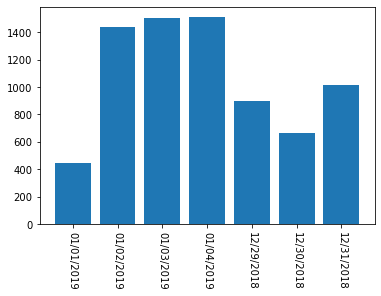

In [155]:
# select 1 turnstile using mask
# {"C/A":"A002",
# "UNIT":"R051",
# "SCP":"02-00-00",
# "STATION":"59 ST"}


# def create_mask(df, diction):
#     for k in diction.keys():
#         mask = df[k]==diction[k]
        

mask = (df["C/A"] == "A002") & (df["UNIT"] == "R051") & (df["SCP"] == '02-00-00') & (df["STATION"] == "59 ST") 
df[mask]



# using a single turnstile plot days by entries


# define a masked dataframe
masked_df = df[mask]


# group df to identify unique turnstiles and dates and aggregate min and max value of entries
agg_masked_df = masked_df.groupby(["C/A","UNIT","SCP","STATION","DATE"]).agg({"ENTRIES":["max","min"]})
# add a column Daily entries by calculating max and min entry value
agg_masked_df["Daily_entries"] = agg_masked_df["ENTRIES"]["max"] - agg_masked_df["ENTRIES"]["min"]
# drop ENTRIES column and reset index so it is single indexed
agg_masked_df.drop(columns="ENTRIES", inplace = True)
agg_masked_df.reset_index(inplace=True)

# plot a bar graph of a entry number of specific turnstile by date
plt.bar(agg_masked_df["DATE"], agg_masked_df["Daily_entries"])

# make the text of x axis so they don't overlap
plt.xticks(range(len(agg_masked_df["DATE"])),agg_masked_df["DATE"], rotation=270 );

In [115]:
# Changes column names
df_MTA_byDate.columns = ["min","max"]

# Reset index
df_MTA_byDate.reset_index(inplace=True)

#Calculates the total number of entries in a day
df_MTA_byDate["max_min"] = df_MTA_byDate["max"] - df_MTA_byDate["min"]

df_MTA_byDate

,C/A,UNIT,SCP,STATION,DATE,min,max,max_min
0,A002,R051,02-00-00,59 ST,01/01/2019,6891983,6892430,447
1,A002,R051,02-00-00,59 ST,01/02/2019,6892452,6893894,1442
2,A002,R051,02-00-00,59 ST,01/03/2019,6893928,6895434,1506
3,A002,R051,02-00-00,59 ST,01/04/2019,6895462,6896974,1512
4,A002,R051,02-00-00,59 ST,12/29/2018,6889287,6890186,899
...,...,...,...,...,...,...,...,...
33503,TRAM2,R469,00-05-01,RIT-ROOSEVELT,01/03/2019,5554,5554,0
33504,TRAM2,R469,00-05-01,RIT-ROOSEVELT,01/04/2019,5554,5554,0
33505,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/29/2018,5554,5554,0
33506,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/30/2018,5554,5554,0


<AxesSubplot:xlabel='DATE'>

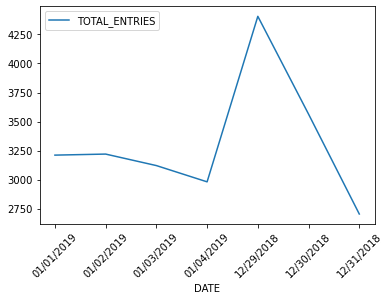

In [119]:
# Challenges 5,6,7
station = ["C/A","UNIT","STATION"]
df_MTA_station_byDate = df_MTA_byDate.groupby(station+["DATE"])["max_min"].sum().reset_index()
df_MTA_station_byDate.rename(columns = {"max_min": "TOTAL_ENTRIES"}, inplace = True)
df_MTA_station_byDate[df_MTA_station_byDate["STATION"] == "RIT-ROOSEVELT"].plot(x="DATE",y="TOTAL_ENTRIES", rot=45)